In [1]:
import pandas as pd

import matplotlib.pyplot as plt


from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\intel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\intel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
base_path = "dataset/"

In [3]:
fakes = pd.read_csv(base_path+"Fake.csv")
news = pd.read_csv(base_path+"True.csv")

In [4]:
news["Class"] = 0
fakes["Class"] = 1

In [11]:
news = pd.concat([news,fakes])
news.head()

,title,text,subject,date,Class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [12]:
import seaborn as sns

Subjects and Date not helping to identify if its Fake or nah. But the title can be just Clickbait, and cannot be a parameter to "look" if its fake or true news

In [14]:
# Therefore we're going to delete them

news = news.drop(columns=["title","subject","date"],axis=1)
news.head()

,text,Class
0,WASHINGTON (Reuters) - The head of a conservat...,0
1,WASHINGTON (Reuters) - Transgender people will...,0
2,WASHINGTON (Reuters) - The special counsel inv...,0
3,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,0


In [15]:
news = news.sample(frac=1)
news.reset_index(inplace=True)
news.drop(["index"], axis=1, inplace=True)

<AxesSubplot:xlabel='Class', ylabel='count'>

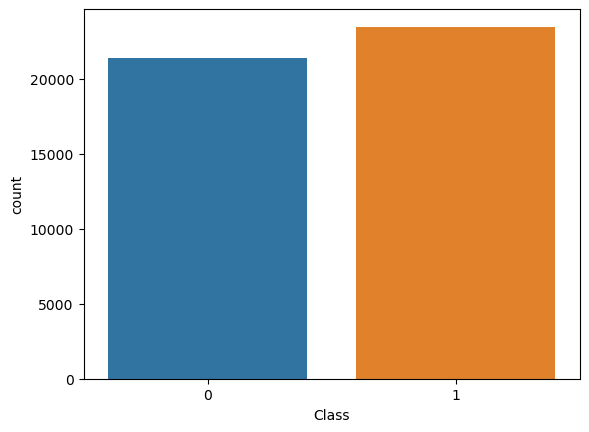

In [16]:
sns.countplot(data=news,x=news.Class)

In [14]:
def preProcess(texts):
    tempText=[]
    
    for sentences in tqdm(texts):
        sentence = re.sub(r'[^\w\s]','',sentences)
        tempText.append(' '.join(token.lower() for token in str(sentence).split() if token not in stopwords.words('english')))
        
    return tempText

In [22]:
preProcess = preProcess(news["text"].values)

100%|██████████| 44898/44898 [2:36:25<00:00,  4.78it/s]   


SavePoint

In [2]:
data = pd.read_csv("PROCESSED.csv")

In [3]:
data = data.drop(columns=["Unnamed: 0"],axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       44898 non-null  object
 1   Class      44898 non-null  int64 
 2   Processed  44267 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


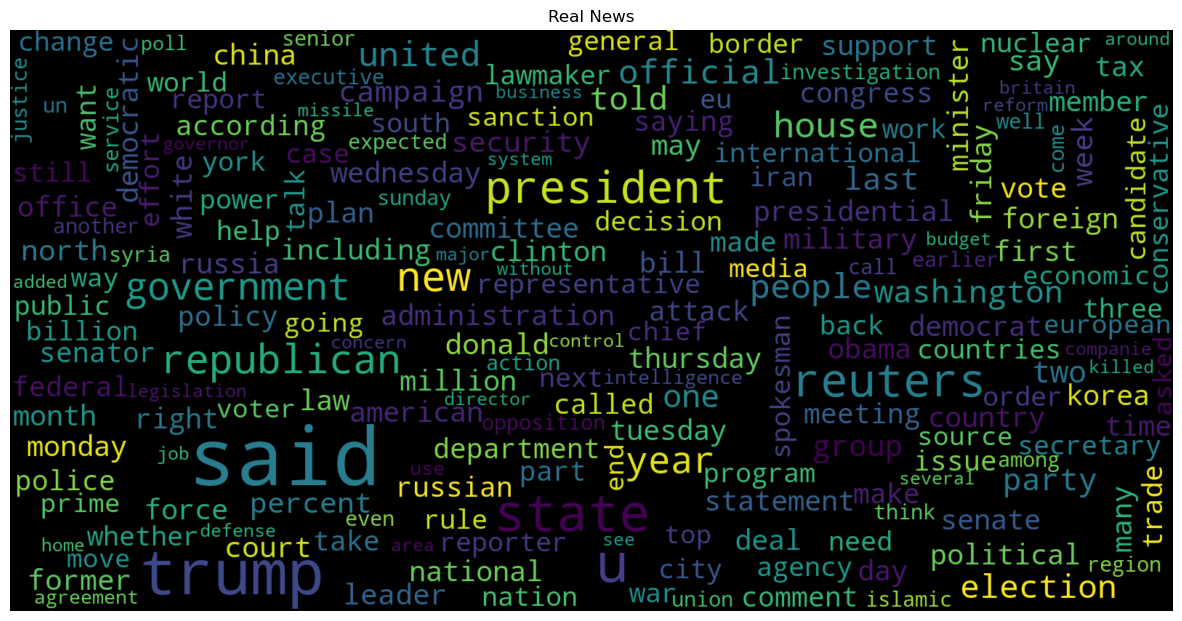

In [4]:

# Real
consolidated = ' '.join(
    word for word in data['Processed'][data['Class'] == 0].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.title("Real News")
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

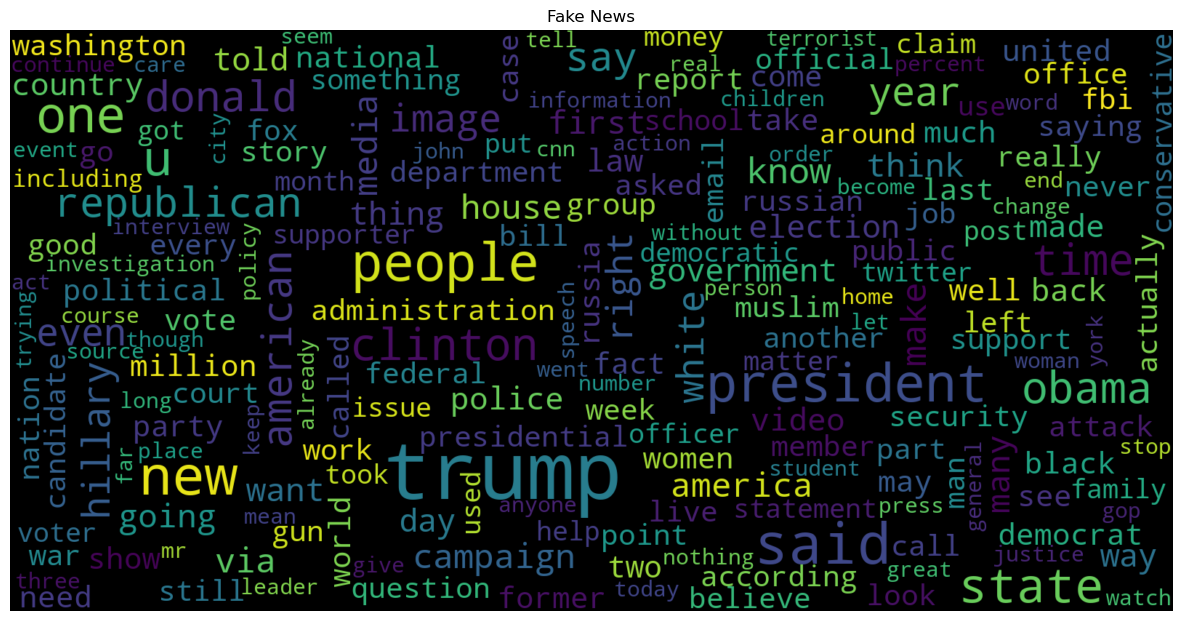

In [5]:

# Fake
consolidated = ' '.join(
    word for word in data['Processed'][data['Class'] == 1].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.title("Fake News")
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<AxesSubplot:title={'center':'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

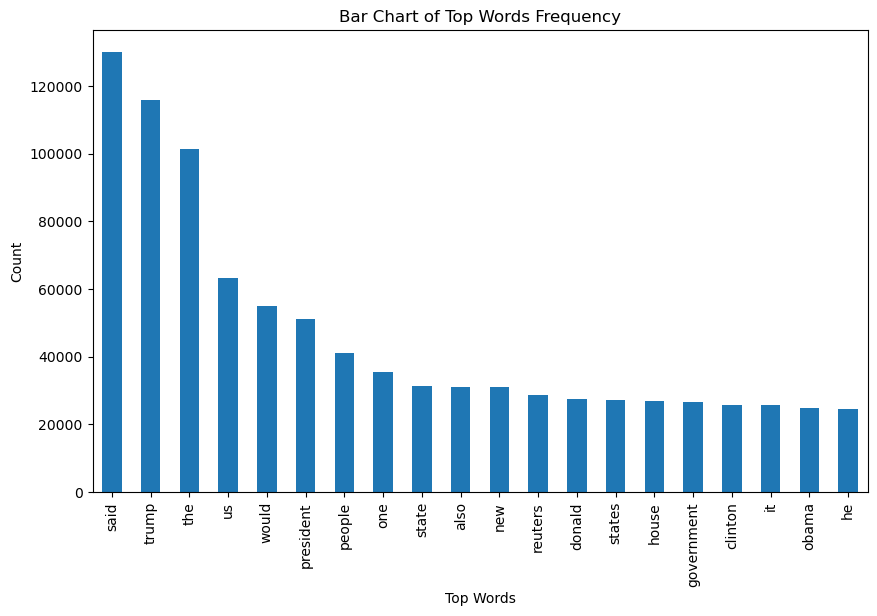

In [6]:

from sklearn.feature_extraction.text import CountVectorizer
  
  
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]
  
  
common_words = get_top_n_words(data['Processed'].astype('str'), 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])
  
df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency")

In [7]:
data.Processed = data.Processed.astype("str")

In [8]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
  
x_train, x_test, y_train, y_test = train_test_split(data['Processed'], 
                                                    data['Class'], 
                                                    test_size=0.25,random_state=0)

In [9]:

from sklearn.feature_extraction.text import TfidfVectorizer
  
vectorization = TfidfVectorizer()
x_train = vectorization.fit_transform(x_train)
x_test = vectorization.transform(x_test)

In [24]:
pickle.dump(vectorization,open("models/vector.pkl","wb"))

In [10]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
  
model = LogisticRegression()
model.fit(x_train, y_train)
  
# testing the model
print(accuracy_score(y_train, model.predict(x_train)))
print(accuracy_score(y_test, model.predict(x_test)))

0.9940902206515606
0.9889532293986637


In [11]:

from sklearn.tree import DecisionTreeClassifier
  
modelTree = DecisionTreeClassifier()
modelTree.fit(x_train, y_train)
  
# testing the model
print(accuracy_score(y_train, modelTree.predict(x_train)))
print(accuracy_score(y_test, modelTree.predict(x_test)))

0.9999703026163395
0.9951893095768374


In [12]:
# Testing Random Input

text = ["""On Sunday, December 4, 2016, a shooting incident occurred at a pizza shop in northwestern Washington D.C. during the middle of the day. This was in a busy but peaceful shopping district, and the shop was filled with families. A man brought a rifle into the shop and began shooting. Fortunately, no one was hurt, and the suspect was arrested, but the motive for this crime and the circumstances that triggered it were shocking.
The pizza shop, called Comet Ping Pong, had become embroiled in a strange situation due to an event that had occurred about one month earlier. There were false tweets widely spread on the net claiming that this pizza shop was the base for a pedophile sex ring involving Democratic presidential candidate Hillary Clinton, a former Secretary of State, and members of her campaign. The operators of the pizza shop began receiving threats from right wing activists who believed that the reports were true.
According to The Washington Post, the trigger was the announcement on October 28 about the resumption of the investigation by the Federal Bureau of investigation (“FBI”) into the issue of the use of private e-mail by Hillary Clinton during her tenure as Secretary of State. Two days later, there was a large volume of tweets about newly-discovered e-mail related to a pedophile sex ring. These posts were spread on anonymous bulletin board sites and via social media; and there were many abusive videos directed at Ms. Clinton posted on extreme-right-wing sites. Two days before the election, the FBI announced that they had reached a conclusion that they would not seek prosecution of Ms. Clinton.
The anonymous bulletin board sites then focused their attention on the pizza shop called Comet Ping Pong, which was frequently mentioned in the e-mail of John Podesta, head of the Clinton campaign, whose e-mails were being successively leaked on the whistle-blower site WikiLeaks at about this same time. This escalated into posts that this shop was the site of child sex trafficking. The day before the voting in the presidential election, the hashtag “#pizzagate” appeared. Even after Ms. Clinton’s defeat the following day, the tweets did not subside, and instead continued to expand. It was reported that the Central Intelligence Agency (“CIA”) had determined that there were cyber-attacks on the e-mail of Democratic Party officials, like Mr. Podesta, indicating that there was intervention from Russia aimed at ensuring that Mr. Trump would win the election; and President Obama demanded a thorough investigation of the government intelligence agencies before his own retirement.
As the number of people who believed in the “pizzagate” conspiracy grew, and the threats directed at the pizza shop increased, the shops in the neighborhood also became involved. The operators of the pizza shop and surrounding businesses said they became frightened by more and more confrontations with people who believed the fake news. Although social media subsequently banned posts related to pizzagate, the threats did not stop, culminating in the appearance of a 28-year-old man from North Carolina, who showed up at the shop with a rifle to do his own “investigation.” According to a New York Times interview with the suspect after his capture, he was a soft-spoken, polite man who intended to rescue the children trapped in the shop.
"""]

In [15]:
text = preProcess(text)
print(text)

100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

['on sunday december 4 2016 shooting incident occurred pizza shop northwestern washington dc middle day this busy peaceful shopping district shop filled families a man brought rifle shop began shooting fortunately one hurt suspect arrested motive crime circumstances triggered shocking the pizza shop called comet ping pong become embroiled strange situation due event occurred one month earlier there false tweets widely spread net claiming pizza shop base pedophile sex ring involving democratic presidential candidate hillary clinton former secretary state members campaign the operators pizza shop began receiving threats right wing activists believed reports true according the washington post trigger announcement october 28 resumption investigation federal bureau investigation fbi issue use private email hillary clinton tenure secretary state two days later large volume tweets newlydiscovered email related pedophile sex ring these posts spread anonymous bulletin board sites via social med

In [16]:
test = vectorization.transform(text)

In [17]:
def predictRandomArticle(text):
    text = preProcess(text)
    text = vectorization.transform(text)
    
    prediction = modelTree.predict(text)
    if prediction == 0 :
        return "Real"
    return "Fake"

In [18]:
print(predictRandomArticle(text))

100%|██████████| 1/1 [00:00<00:00, 10.44it/s]

Fake


In [19]:
import joblib


In [20]:
import pickle

def saveModel(model,modelName):
    savePath = f"models/{modelName}.pkl"
    
    pickle.dump(model,open(savePath, "wb"))
    
    return True

In [21]:
saveModel(model,"linear")

True